<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/02_variational_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook

In [39]:
from datasets import load_dataset

import torch
import torchsummary
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib as mpl
from matplotlib import pyplot as plt

from genaibook.core import show_images
from genaibook.core import get_device

from tqdm.notebook import tqdm, trange

import pandas as pd
import numpy as np

## Dataset

In [ ]:
mnist = load_dataset("mnist")

In [4]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
mnist["train"]["image"][1]

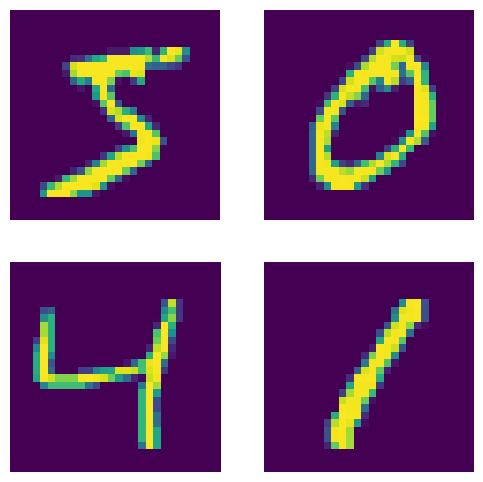

In [6]:
# let's show them with higher resolution
show_images(mnist["train"]["image"][:4])

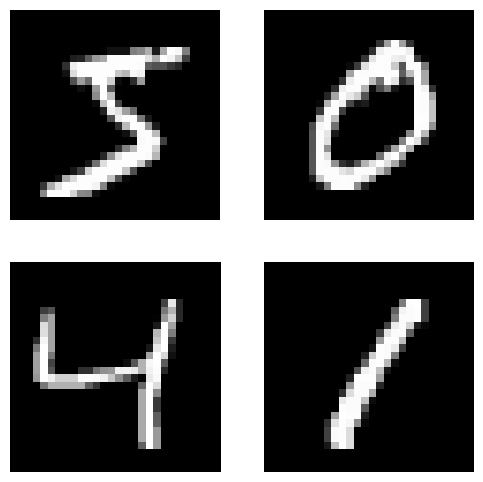

In [7]:
# let's configure matplotlib to just use gray colors instead
mpl.rcParams["image.cmap"] = "gray"
show_images(mnist["train"]["image"][:4])

In [8]:
torch.manual_seed(1337);

# let's convert the images to PyTorch tensors and shuffle the training dataset
def mnist_to_tensor(example):
  t = transforms.ToTensor()
  example["image"] = [t(img) for img in example["image"]]
  return example

mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [9]:
# Let’s check out a single image from the dataset
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

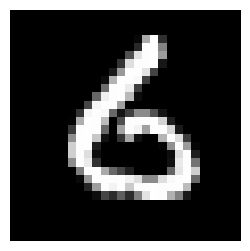

In [10]:
show_images([x])

In [11]:
# Let's now create a PyTorch DataLoader to prepare the training data
bs = 64
# just need image column of the dataset and ignore the labels
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

## Modeling AutoEncoder

In [29]:
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

def conv_transpose_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0, with_act=True):
  models = [
      nn.ConvTranspose2d(
          in_channels,
          out_channels,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding,
          output_padding=output_padding),
  ]
  if with_act:
    models.append(nn.BatchNorm2d(out_channels))
    models.append(nn.ReLU())
  return nn.Sequential(*models)

In [30]:
class Encoder(nn.Module):
  def __init__(self, in_channels, latent_dims):
    super().__init__()

    self.conv_layers = nn.Sequential(
      conv_block(in_channels, 128),
      conv_block(128, 256),
      conv_block(256, 512),
      conv_block(512, 1024),
    )

    self.linear = nn.Linear(1024, latent_dims)

  def forward(self, x):
    bs = x.shape[0]
    x = self.conv_layers(x)
    x = self.linear(x.reshape(bs, -1))
    return x

In [31]:
class Decoder(nn.Module):
  def __init__(self, out_channels, latent_dims):
    super().__init__()

    self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
    self.t_conv_layers = nn.Sequential(
      conv_transpose_block(1024, 512),
      conv_transpose_block(512, 256, output_padding=1),
      conv_transpose_block(256, out_channels, output_padding=1, with_act=False),
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    bs = x.shape[0]
    x = self.linear(x)
    x = x.reshape(bs, 1024, 4, 4)
    x = self.t_conv_layers(x)
    x = self.sigmoid(x)
    return x

In [32]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, latent_dims):
    super().__init__()
    self.encoder = Encoder(in_channels, latent_dims)
    self.decoder = Decoder(in_channels, latent_dims)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    return self.decode(self.encode(x))

In [33]:
def train(model, num_epochs=10, lr=1e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

  model.train() # Put model in training mode
  losses = []
  for _ in (progress:=trange(num_epochs, desc="Training")):
    for _, batch in (inner:=tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
      batch = batch.to(device)

      # Pass through the model and obtain another set of images
      preds = model(batch)

      # Compare the prediction with the original images
      loss = F.mse_loss(preds, batch)

      # Display loss and store for plotting
      inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
      losses.append(loss.item())

      # Update the model parameters with the optimizer based on this loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
  return losses

In [34]:
device = get_device()
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [35]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

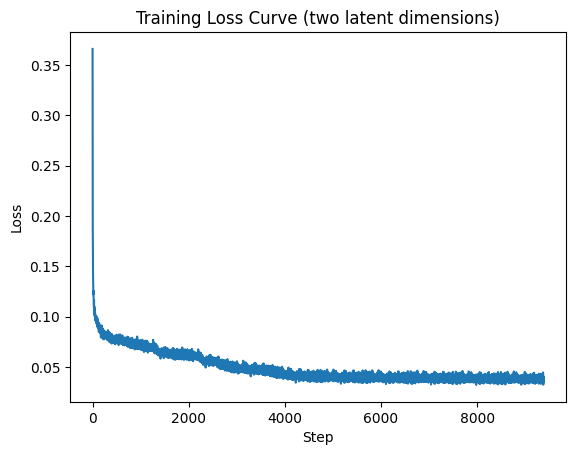

In [36]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [37]:
# Let’s once again load the trained model and look at some reconstructions
ae_model.eval()
with torch.inference_mode():
  eval_batch = next(iter(eval_dataloader))
  predicted = ae_model(eval_batch.to(device)).cpu()

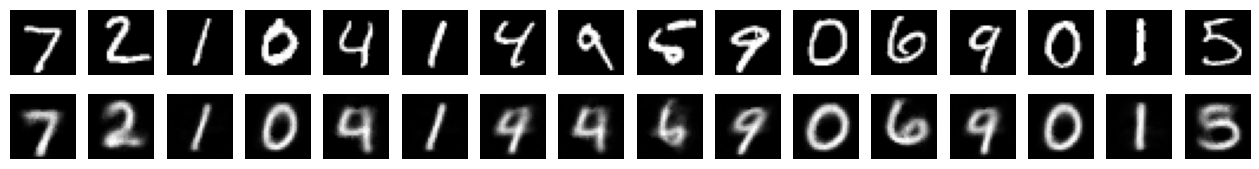

In [38]:
# let’s display the original images and their reconstructions
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## Modeling VAE

In [12]:
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [13]:
class VAEEncoder(nn.Module):
  def __init__(self, in_channels, latent_dims):
    super().__init__()

    self.conv_layers = nn.Sequential(
      conv_block(in_channels, 128),
      conv_block(128, 256),
      conv_block(256, 512),
      conv_block(512, 1024),
    )

    # Define fully connected layers for mean and log-variance
    self.mu = nn.Linear(1024, latent_dims)     # will learn the mean of the distribution
    self.logvar = nn.Linear(1024, latent_dims) # will learn the variance of the distribution

  def forward(self, x):
    bs = x.shape[0]
    x = self.conv_layers(x)
    x = x.reshape(bs, -1)
    mu = self.mu(x)
    logvar = self.logvar(x)
    return (mu, logvar)

In [14]:
def conv_transpose_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0, with_act=True):
  models = [
      nn.ConvTranspose2d(
          in_channels,
          out_channels,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding,
          output_padding=output_padding),
  ]
  if with_act:
    models.append(nn.BatchNorm2d(out_channels))
    models.append(nn.ReLU())
  return nn.Sequential(*models)

class Decoder(nn.Module):
  def __init__(self, out_channels, latent_dims):
    super().__init__()

    self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
    self.t_conv_layers = nn.Sequential(
      conv_transpose_block(1024, 512),
      conv_transpose_block(512, 256, output_padding=1),
      conv_transpose_block(256, out_channels, output_padding=1, with_act=False),
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    bs = x.shape[0]
    x = self.linear(x)
    x = x.reshape(bs, 1024, 4, 4)
    x = self.t_conv_layers(x)
    x = self.sigmoid(x)
    return x

In [15]:
class VAE(nn.Module):
  def __init__(self, in_channels, latent_dims):
    super().__init__()
    self.encoder = VAEEncoder(in_channels, latent_dims)
    self.decoder = Decoder(in_channels, latent_dims)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def sample(self, mu, std):
    # Reparametrization trick
    # Sample from N(0, I), translate and scale
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    # Obtain parameters of the normal (Gaussian) distribution
    mu, logvar = self.encode(x)

    # Sample from the distribution
    std = torch.exp(0.5 * logvar)
    z = self.sample(mu, std)

    # Decode the sampled vector
    reconstructed = self.decode(z)

    # Return the reconstructed image, and also the mu and logvar so we can compute a distribution loss
    return reconstructed, mu, logvar

In [16]:
def vae_loss(batch, reconstructed, mu, logvar):
  bs = batch.shape[0]

  # Reconstruction loss from the pixels - 1 per image: Measures how much the output images resemble the originals
  reconstruction_loss = F.mse_loss(
      reconstructed.reshape(bs, -1),
      batch.reshape(bs, -1),
      reduction="none"
  ).sum(dim=-1)

  # KL-divergence loss, per input image: Measures how well the features follow a Gaussian distribution
  kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

  # Combine both losses and get the mean across images
  total_loss = (reconstruction_loss + kl_divergence_loss).mean(dim=0)

  return (total_loss, reconstruction_loss, kl_divergence_loss)

In [17]:
device = get_device()

def train_vae(model, num_epochs=10, lr=1e-4):
  model = model.to(device)
  losses = {
      "loss": [],
      "reconstruction_loss": [],
      "kl_divergence_loss": []
  }
  model.train() # Put model in training mode
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

  for _ in (progress:=trange(num_epochs, desc="Training")):
    for _, batch in (inner:=tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
      batch = batch.to(device)

      # Pass through the model and obtain another set of images
      reconstructed, mu, logvar = model(batch)

      # Compare the prediction with the original images
      loss, reconstruction_loss, kl_divergence_loss = vae_loss(batch, reconstructed, mu, logvar)

      # Display loss and store for plotting
      inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
      losses["loss"].append(loss.item())
      losses["reconstruction_loss"].append(reconstruction_loss.mean().item())
      losses["kl_divergence_loss"].append(kl_divergence_loss.mean().item())

      # Update the model parameters with the optimizer based on this loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
  return losses

In [18]:
vae_model = VAE(in_channels=1, latent_dims=2)

In [19]:
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

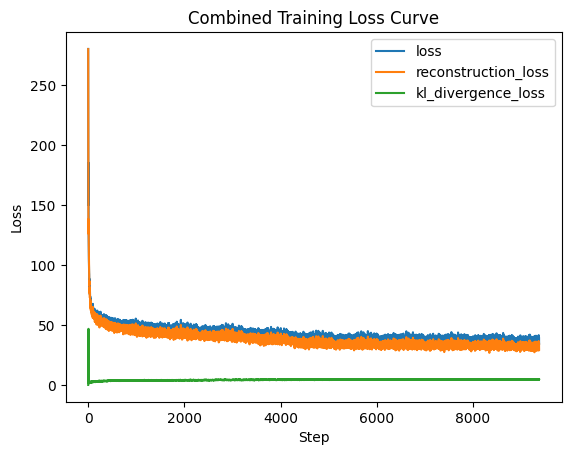

In [20]:
# Let’s now plot the loss components while training a VAE
for k, v in losses.items():
  plt.plot(v, label=k)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Combined Training Loss Curve")
plt.legend();

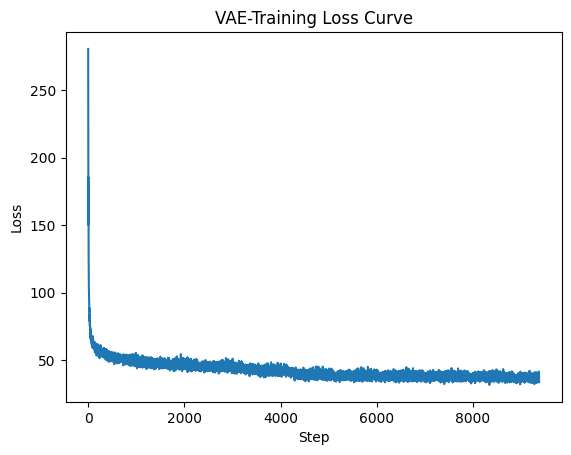

In [21]:
# Let’s plot the loss components separately to see how they evolve during training
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE-Training Loss Curve")
plt.show()

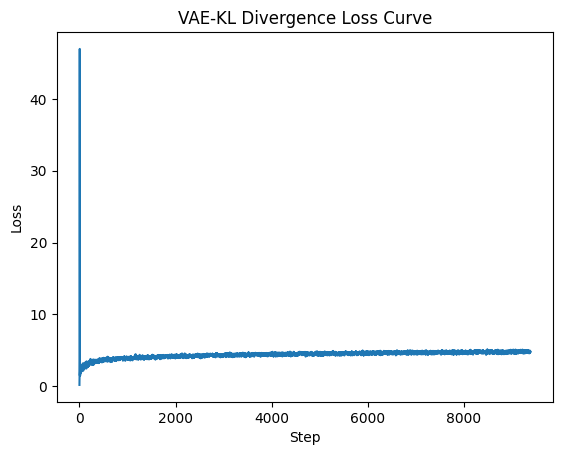

In [22]:
plt.plot(losses["kl_divergence_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE-KL Divergence Loss Curve")
plt.show()

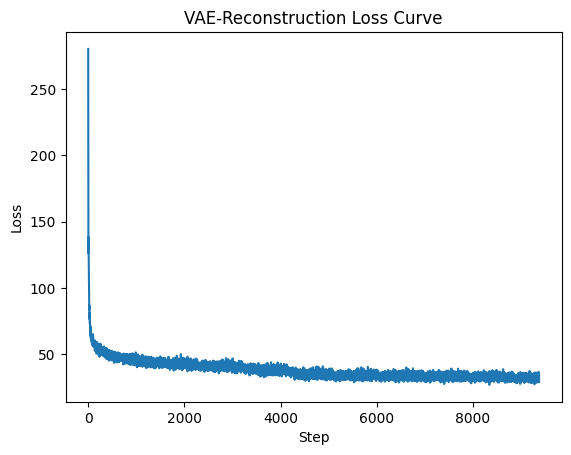

In [23]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE-Reconstruction Loss Curve")
plt.show()

In [24]:
# Let’s reconstruct some images and visualize the results
vae_model.eval()
with torch.inference_mode():
  eval_batch = next(iter(eval_dataloader))
  predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

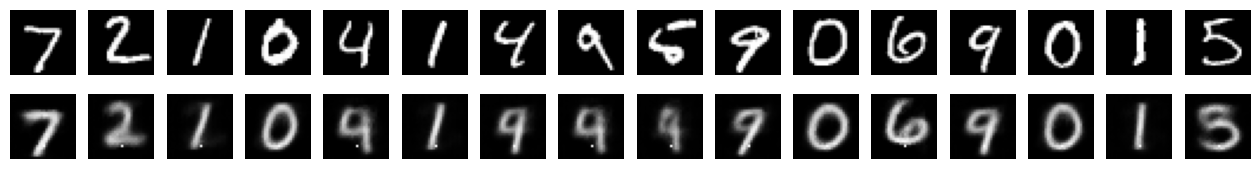

In [25]:
# let’s display the original images and their reconstructions
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## Visualizing the Latent Space

Let’s now represent all the encoded vectors from the test dataset, using the label column to assign different colors to each class.

In [26]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [27]:
df = pd.DataFrame({
    "x": [],
    "y": [],
    "label": []
})

for _, batch in tqdm(enumerate(images_labels_dataloader), total=len(images_labels_dataloader)):
  mu, _ = vae_model.encode(batch["image"].to(device))
  mu = mu.to("cpu")
  new_items = pd.DataFrame({
      "x": [t.item() for t in mu[:, 0]],
      "y": [t.item() for t in mu[:, 1]],
      "label": batch["label"]
  })
  df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

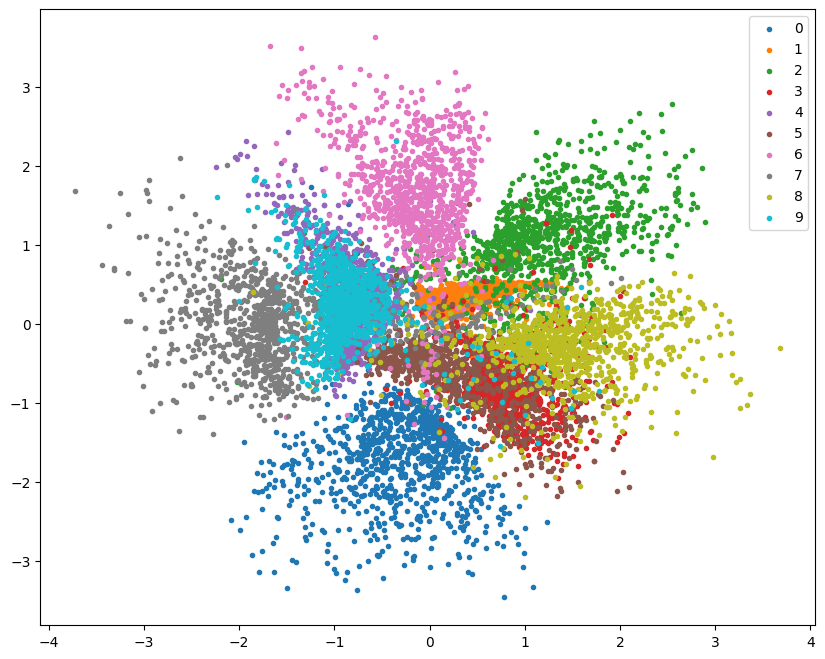

In [28]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

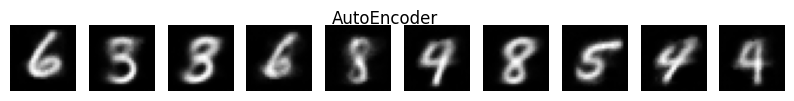

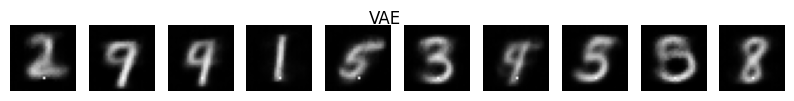

In [40]:
# # Let’s see how it works for both the AutoEncoder and the VAE
z = torch.normal(0, 1, size=(10, 2))
ae_decoded = ae_model.decode(z.to(device)).cpu()
vae_decoded = vae_model.decode(z.to(device)).cpu()

show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")
show_images(vae_decoded.cpu(), imsize=1, nrows=1, suptitle="VAE")

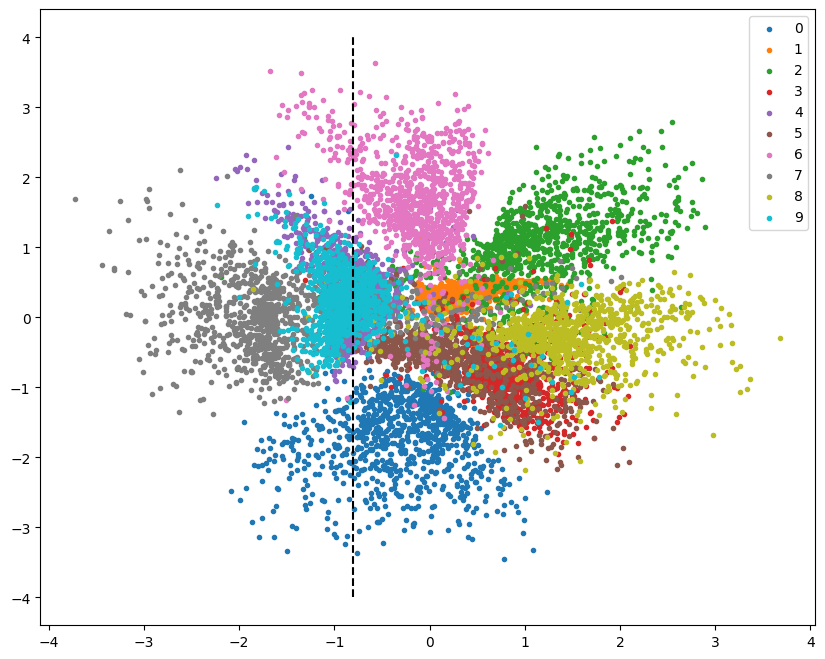

In [41]:
# A fun exercise is to show how representations morph as we travel in 2D through latent space.
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

# fix a vertical line at x = -0.8
plt.vlines(-0.8, ymin=-4, ymax=4, linestyle="dashed", colors="black")
plt.legend();

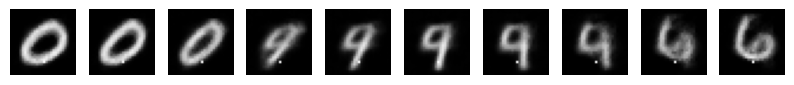

In [42]:
# If we select points from y = -2 to y = 2, we see that the reconstructions match the
# latent space areas that represent various numbers
with torch.inference_mode():
  inputs = []
  for y in np.linspace(-2, 2, 10):
    inputs.append([-0.8, y])
  z = torch.tensor(inputs, dtype=torch.float32).to(device)
  vae_encoded = vae_model.decode(z)
show_images(vae_encoded.cpu(), imsize=1, nrows=1)

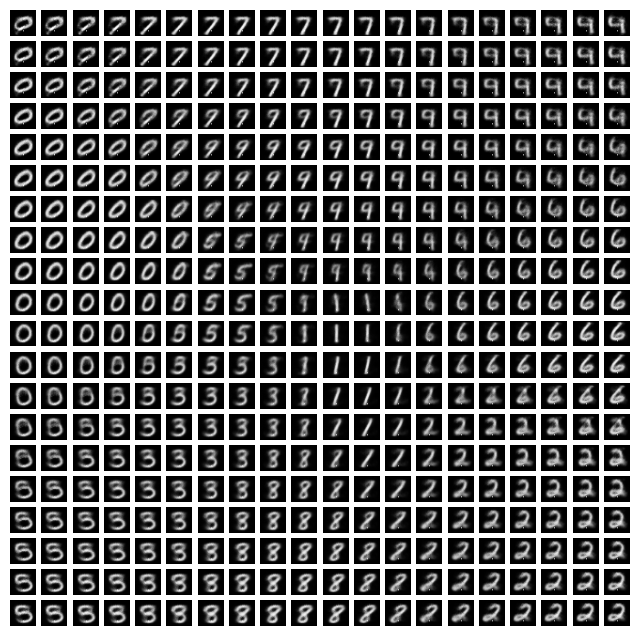

In [43]:
# Let’s expand the idea of exploring the latent space to a 2D grid
with torch.inference_mode():
  inputs = []
  for x in np.linspace(-2, 2, 20):
    for y in np.linspace(-2, 2, 20):
      inputs.append([x, y])
  z = torch.tensor(inputs, dtype=torch.float32).to(device)
  vae_encoded = vae_model.to(device).decode(z)
show_images(vae_encoded.cpu(), imsize=0.4, nrows=20)